In [ ]:
%pip install --upgrade pip
%pip install numpy networkx scipy joblib
import Sequencer

In [2]:
# imports
%matplotlib inline


import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from astropy.io import fits
from astropy.table import Table
from astropy.table import QTable
from astropy import units as u
from astropy.wcs import WCS
from astropy.visualization import quantity_support
from matplotlib.colors import LogNorm
import glob
import requests
import matplotlib as mpl
import matplotlib.cm as cm
import requests
import json

In [3]:
path_fits = 'dataset/fits/'
path_json = 'dataset/fits.json'

PATH_FILE = "PATH_FILE"
SPEC = "SPEC"
PLATE = "PLATE"
REDSHIFT = "REDSHIFT"

fits_json_object = json.load(open(path_json))

In [4]:
def fit_polynom(lambda_x, a0, a1, a2, a3):
    """fit func = 2 nd order polynom"""
    return a0+a1*lambda_x+a2*(lambda_x)**2+a3*(lambda_x)**3
init_fit_param = [0, 0, 0, 0]

The code below will allow us to compile all the spectra information of the galaxies, based on the redshift filtering done. Here it can be changed to take into consideration different galaxies at differente redshift values.

In [5]:
spectra_list = []
wavelength_list = []
flux_raw_list = []
lamb_list = []
lambd_list = []
flux_bin_list = []
spectrax_list = []
esp_al_sec_list = []
lam_al_sec_list = []
#test_list = []

it = iter(fits_json_object)
for f in it:
    if float(f[REDSHIFT]) > 0.1 and f[REDSHIFT] < 0.2:
        #opens fits file
        h = fits.open(f[PATH_FILE], memmap=True)
        data = h[1].data
        name = (h.filename())[-25:-5]
        if name == 'spec-1186-52646-0261':
            continue
        # Redshift value for AGN processed
        z = f[REDSHIFT]
        # flux and wavelenght from fits file
        lamb = 10**data['loglam']
        flux_raw = data['flux']
        # rest-frame wavelength
        lambd = lamb/(1+z)
        #common wavelength grid from 4000˚ A to 7000
        lambda_bin=np.arange(3001)+4000.
        #interpolate flux to common wavelengh 
        flux_bin = interp1d(lambd, flux_raw, kind='cubic')(lambda_bin)
        #Especify spectra interval to be removed as flux continuum
        lam=np.concatenate((lambda_bin[190:215],lambda_bin[1090:1110], lambda_bin[1400:1750], lambda_bin[2195:2215], lambda_bin[2840:2860]))
        flu=np.concatenate((flux_bin[190:215],flux_bin[1090:1110], flux_bin[1400:1750], flux_bin[2195:2215], flux_bin[2840:2860]))
        # fit data using scipy.curve_fit()
        fit_params, fit_covariances = curve_fit(fit_polynom, lam, flu, p0=init_fit_param)
        # remove continuum by substracting flux by fit polynomial
        flux = (flux_bin - (fit_polynom(lambda_bin, *fit_params)))
        # Normalize spectra so the result of the integral is 1
        total_flux = flux / np.sum(flux)
        # Appends the result to the final list
        spectra_list.append(total_flux)
 
        
        #List compilation fro graph purposes
        lamb_list.append(lamb)
        flux_raw_list.append(flux_raw)
        spectrax_list.append(flux)
        lambd_list.append(lambd)
        flux_bin_list.append(flux_bin)
        wavelength_list.append(lambda_bin)

        # code for Hidrogen Alpha spectral interval
        #esp_al_sec=flux[2330:2800]/np.sum(flux[2330:2800])
        #lam_al_sec=lambda_bin[2330:2800]
        #esp_al_sec_list.append(esp_al_sec)
        #lam_al_sec_list.append(lam_al_sec)
        
print("number of stellar spectra: %s" % len(spectra_list))
print("length of each spectrum: %s" % len(spectra_list[0]))

number of stellar spectra: 451
length of each spectrum: 3001


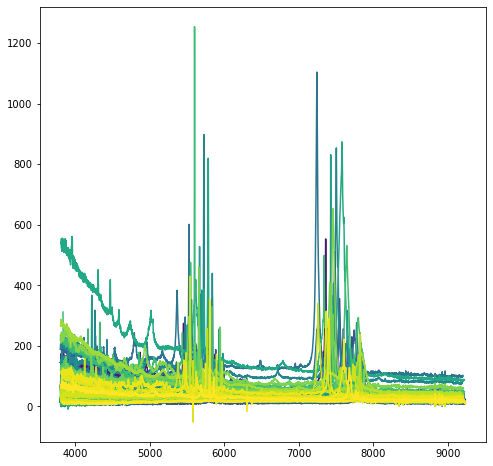

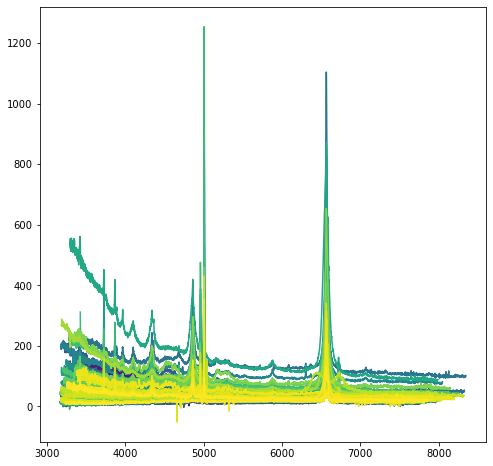

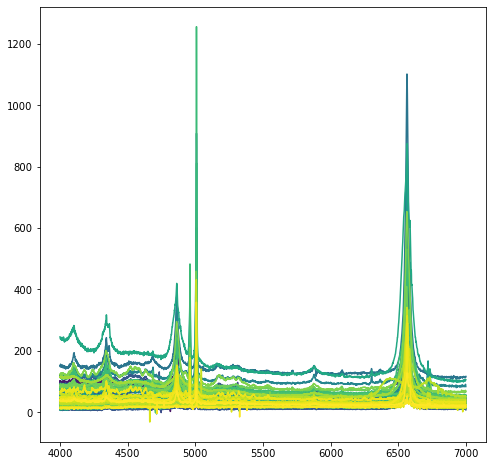

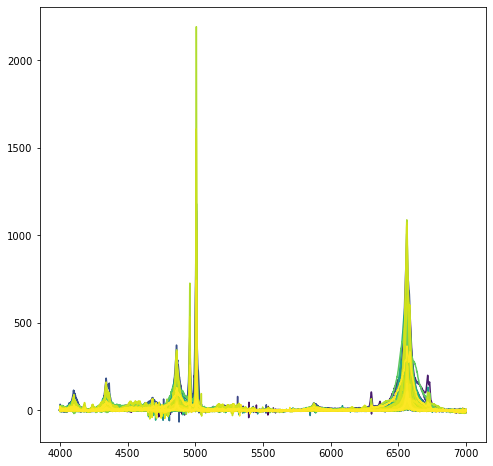

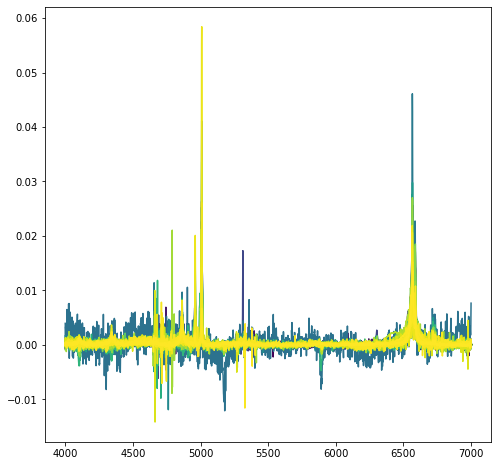

In [6]:
########################## ploting option ################################################
norm = mpl.colors.Normalize(vmin=0, vmax=len(spectra_list)-1)
cmap = cm.viridis
m = cm.ScalarMappable(norm=norm, cmap=cmap)

plt.figure(1, figsize=(8, 8))
for i in range(0, len(spectra_list), 5):
    plt.plot(lamb_list[i], flux_raw_list[i], color=m.to_rgba(i))

########################## ploting option ################################################
plt.figure(2, figsize=(8, 8))
for i in range(0, len(spectra_list), 5):
    plt.plot(lambd_list[i], flux_raw_list[i], color=m.to_rgba(i))

########################## ploting option ################################################
plt.figure(3, figsize=(8, 8))
for i in range(0, len(spectra_list), 5):
    plt.plot(wavelength_list[i], flux_bin_list[i], color=m.to_rgba(i)) #ok hasta aqui

########################## ploting option ################################################
plt.figure(4, figsize=(8, 8))
for i in range(0, len(spectra_list)):
    plt.plot(wavelength_list[i], spectrax_list[i], color=m.to_rgba(i))

########################## ploting option ################################################
plt.figure(5, figsize=(8, 8))
for i in range(0, len(spectra_list)):
    plt.plot(wavelength_list[i], spectra_list[i], color=m.to_rgba(i))

########################## ploting option ################################################
#plt.figure(6, figsize=(8, 8))
#for i in range(0, len(spectra_list)):
    #plt.plot(lam_al_sec_list[i], esp_al_sec_list[i], color=m.to_rgba(i))

(3001,) (451, 3001)


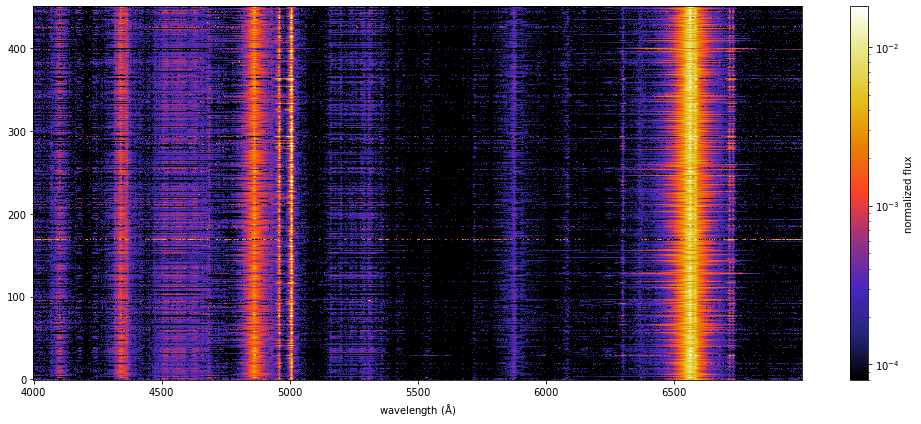

In [8]:
# load the spectra and construct the wavelength range 
wavelength = np.arange(3999, 7000, 1)
spectra_matrix = np.asarray(spectra_list)
print(wavelength.shape, spectra_matrix.shape)

indices_for_plot = np.arange(len(spectra_matrix))
X, Y = np.meshgrid(wavelength, indices_for_plot)

plt.figure(1, figsize=(14, 6))
plt.pcolormesh(X, Y, spectra_matrix.clip(0.00008, 0.018), cmap="CMRmap", norm=LogNorm(), shading='auto')
plt.xlabel("wavelength ($\\mathrm{\\AA}$)")
plt.colorbar(label="normalized flux")
plt.tight_layout()

In [9]:
## Normalizing dataset (Min-Max normalization)
spectrum = spectra_matrix.data
n1 = spectrum - np.min(spectrum)
n2 = np.max(spectrum) - np.min(spectrum)
norm_spectrum = n1/n2

We run the sequencer witht the normalized dataset calculated in previous steps:

Parallelization is ON. Number of cores: 16
calculating the distance matrices for estimator: EMD, scale: 1
finished calculating this distance matrix list, it took: 4.818203926086426 seconds
calculating the distance matrices for estimator: EMD, scale: 2
finished calculating this distance matrix list, it took: 5.505091905593872 seconds
calculating the distance matrices for estimator: EMD, scale: 10
finished calculating this distance matrix list, it took: 14.807012557983398 seconds
calculating the distance matrices for estimator: energy, scale: 1
finished calculating this distance matrix list, it took: 4.34621000289917 seconds
calculating the distance matrices for estimator: energy, scale: 2
finished calculating this distance matrix list, it took: 5.292178392410278 seconds
calculating the distance matrices for estimator: energy, scale: 10
finished calculating this distance matrix list, it took: 15.268404245376587 seconds
calculating the distance matrices for estimator: L2, scale: 1
finishe

C:\Users\davos\AppData\Local\Temp/ipykernel_23524/533716621.py:893: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ordering_bfs = numpy.array(ordering_bfs).astype(numpy.int)


in estimator: EMD, scale: 2
in estimator: EMD, scale: 10
in estimator: energy, scale: 1
in estimator: energy, scale: 2
in estimator: energy, scale: 10
in estimator: L2, scale: 1
in estimator: L2, scale: 2
in estimator: L2, scale: 10
dumped the elongations to the file: dataset/fits//elongations.pkl
dumped the full weighted distance matrix to the file: dataset/fits//weighted_distance_matrix.pkl
dumped the sparse distance matrix to the file: <_io.BufferedWriter name='dataset/fits//sparse_distance_matrix.pkl'>
dumped the final sequences and elongation to the file: <_io.BufferedWriter name='dataset/fits//final_products.pkl'>
resulting elongation for the Sequencer:  13.098858904331838
Intermediate elongations for the different metrics and scales:
metric=EMD, scale=1, elongation: 12.16
metric=EMD, scale=2, elongation: 8.59
metric=EMD, scale=10, elongation: 9.61
metric=energy, scale=1, elongation: 13.1
metric=energy, scale=2, elongation: 8.4
metric=energy, scale=10, elongation: 7.26
metric=L2,

C:\Users\davos\AppData\Local\Temp/ipykernel_23524/533716621.py:1021: RuntimeWarning: divide by zero encountered in true_divide
  distance_matrix = 1.0 / proximity_matrix_copy


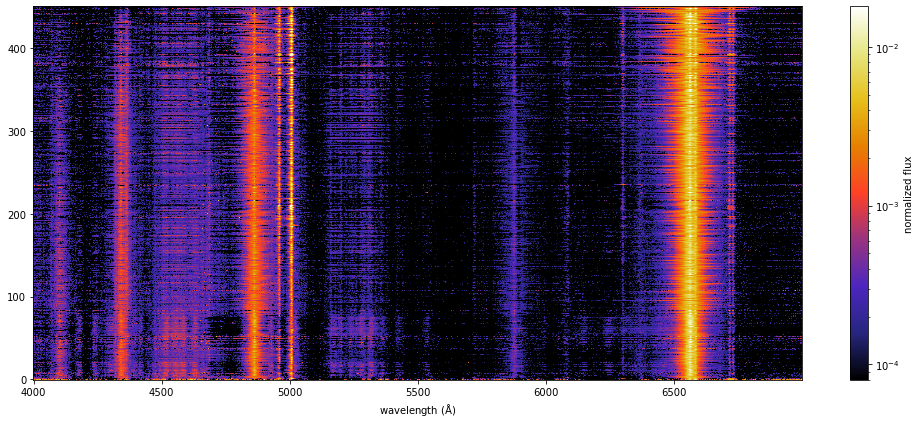

In [19]:
estimator_list = ['EMD','energy', 'L2']
scale_list = [[1,2,10], [1,2,10], [1,2,10]]
seq = Sequencer(wavelength, norm_spectrum, estimator_list, scale_list)
output_path = 'dataset/fits/'
final_elongation, final_sequence = seq.execute(output_path, to_average_N_best_estimators=True, 
                                              number_of_best_estimators=3,
                                              to_use_parallelization=True)
print("resulting elongation for the Sequencer: ", final_elongation)

# print the intermediate elongations for different metrics + scales
estimator_list, scale_list, elongation_list = seq.return_elongation_of_weighted_products_all_metrics_and_scales()

print("Intermediate elongations for the different metrics and scales:")
for i in range(len(estimator_list)):
    print("metric=%s, scale=%s, elongation: %s" % (estimator_list[i], 
                                                   scale_list[i], 
                                                   numpy.round(elongation_list[i], 2)))

# order the input dataset according to the detected sequence
objects_list_ordered = spectra_matrix[final_sequence, :]
# plot the ordered dataset
plt.figure(1, figsize=(14, 6))
plt.pcolormesh(X, Y, objects_list_ordered.clip(0.00008, 0.018), cmap="CMRmap", norm=LogNorm(), shading='auto')
plt.xlabel("wavelength ($\\mathrm{\\AA}$)")
plt.colorbar(label="normalized flux")
plt.tight_layout()

### Comparison to original dataset:

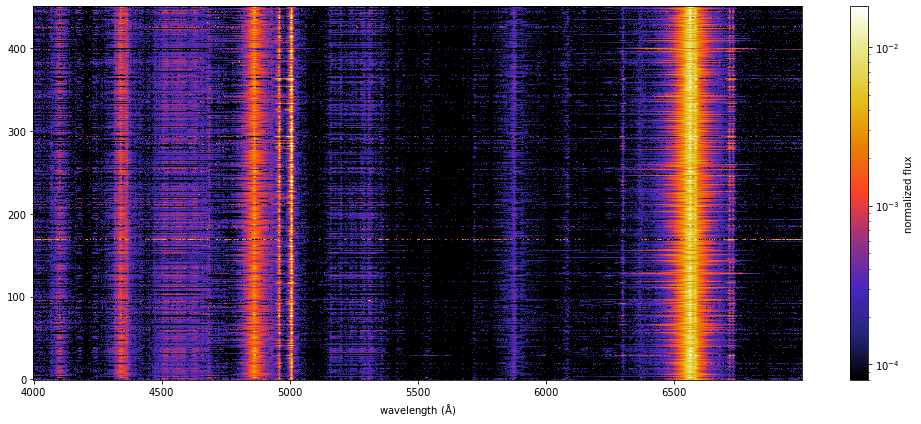

In [21]:
plt.figure(1, figsize=(14, 6))
plt.pcolormesh(X, Y, spectra_matrix.clip(0.00008, 0.018), cmap="CMRmap", norm=LogNorm(), shading='auto')
plt.xlabel("wavelength ($\\mathrm{\\AA}$)")
plt.colorbar(label="normalized flux")
plt.tight_layout()

Now we print out the Minimum Spanning Tree

In [22]:
final_mst = seq.return_final_MST()
type(final_mst)

networkx.classes.graph.Graph

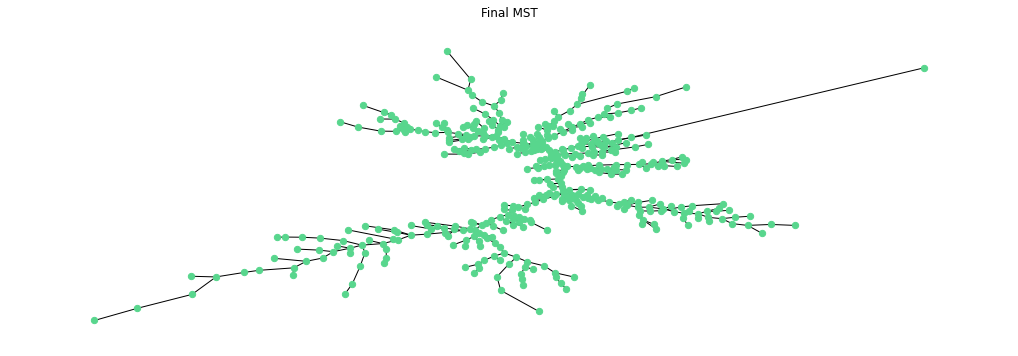

In [23]:
plt.figure(1, figsize=(18, 6))
plt.title("Final MST")
pos = nx.kamada_kawai_layout(final_mst)
nx.draw(final_mst, pos, node_color="#58D68D", node_size=40)